# Making a decorrelated anti-QCD tagger with PCA rescaling

This code shows how to import data, bin it in jet mass, do PCA preprocessing, and show jet mass distributions after tagger selection

## Part 0: Initialize and define the preprocessing classes

An instance of the class mysplit_n_scale will take as it's input a list of events (M, {tau_N^beta}), bins the events in mass, and within each bin performs the PCA standardisation. The output is a binned list of tau^(PCA) data. It requires a binning for initialisation, for our paper we used standard_binboundaries defined below, chosen to have good statistics in each bin.

There as also myscaler, which does unbinned std rescaling.

In [1]:
import numpy as np
import numpy.random as rand
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

#This is the binning we used in the paper
standard_binboundaries = np.concatenate((np.arange(0,25,25),
                                         np.arange(25,35,10),
                                         np.arange(35,215,5),
                                         np.arange(215,275,10),
                                         np.arange(275,300,25),
                                         np.arange(300,450,50),
                                         np.arange(450,560,100)))

#This class does std rescaling
class myscaler:
    
    def __init__(self, mybgdata):
        self.scale1 = preprocessing.StandardScaler().fit(mybgdata)
        tempdata = self.scale1.transform(mybgdata)
        self.mypca = PCA().fit(tempdata)
        tempdata = self.mypca.transform(tempdata)
        self.scale2 = preprocessing.StandardScaler().fit(tempdata)
        
    def transform(self,inputdata):
        return np.dot(self.scale2.transform(self.mypca.transform(self.scale1.transform(inputdata))),
                      self.mypca.components_)

#This class does PCA rescaling
class mysplit_n_scale:
    
    def __init__(self, mybgdata, mybinboundaries = standard_binboundaries):
        self.binboundaries = mybinboundaries
        bgdatabinned = []
        for i in range(0,len(mybinboundaries)-1):
            bgdatabinned.append(
                np.array([myrow[1:] for myrow in mybgdata if (myrow[0] < mybinboundaries[i+1] and myrow[0] >= mybinboundaries[i])])
            )
        
        self.scale1 = [preprocessing.StandardScaler().fit(databin) for databin in bgdatabinned]
        tempdata = [self.scale1[i].transform(databin) for i, databin in enumerate(bgdatabinned)]
        self.mypca = [PCA().fit(tempdatarow) for tempdatarow in tempdata]
        newtempdata = [self.mypca[i].transform(tempdatarow) for i, tempdatarow in enumerate(tempdata)]
        self.scale2 = [preprocessing.StandardScaler().fit(tempdatarow) for tempdatarow in newtempdata]
        
    def transform(self,inputdata):
        inputdatabinned = []
        for i in range(0,len(self.binboundaries)-1):
            inputdatabinned.append(
                np.array([myrow[1:] for myrow in inputdata
                         if (myrow[0] < self.binboundaries[i+1] and myrow[0] >= self.binboundaries[i])])
            )
        scaleddatabinned = [np.dot(self.scale2[i].transform(self.mypca[i].transform(self.scale1[i].transform(inputdatarow))),
                                    self.mypca[i].components_)
                            if len(inputdatarow) > 0 else []
                            for i, inputdatarow in enumerate(inputdatabinned)]
        return scaleddatabinned

## Part 1: Load and process QCD data and signal training data

The QCD data is located in ./no-mass-cut-data/Zg-PT1000.all.dat and ./no-mass-cut-data/Zq-PT1000.all.dat. It was generated as p p > Z q/g, Z > nu nu. The label PT1000 means the jet was selected with cut pT > 1000 GeV.

We arbitrarily chose to use a 50/50 mix of quark and gluon data.

The format of the data files is as follows. Each row is one jet (one event). The first column is (ungroomed) jet mass, the rest of the columns are tau_N^beta values for the jet. The tau_N^beta basis was taken from [arXiv:1704.08249] (Larkoski, Data, 'How much information is in a jet?'. The ordering is:

(M_J, tau_1^1, tau_2^1, tau_3^1, tau_4^1, tau_5^1, tau_6^1, tau_1^2, tau_2^2, tau_3^2, tau_4^2, tau_5^2, tau_6^2, tau_1^0.5, tau_2^0.5, tau_3^0.5, tau_4^0.5, tau_5^0.5)

In [2]:
#Load data
data_prefix = './no-mass-cut-data/'
bg_nameg = 'Zg-PT1000'
bg_nameq = 'Zq-PT1000'

bgdatag = np.loadtxt(data_prefix + bg_nameg + '.all.dat')
bgdataq = np.loadtxt(data_prefix + bg_nameq + '.all.dat')

#Take a 50/50 mix of quark and gluon data
minlength = min(len(bgdatag),len(bgdataq))
bgdata = np.append(bgdatag[:minlength+1],bgdataq[:minlength+1],axis=0)
#Randomize ordering
rand.shuffle(bgdata)

### Initialize an instance of the PCA preprocessor class

In [3]:
#Initialize the PCA preprocessor
preprocessor = mysplit_n_scale(bgdata)
#PCA preprocess data. This results in a binned dataset
bgdatabinned = preprocessor.transform(bgdata)

Here we just get the bin boundaries, centers, widths, etc.

In [4]:
binboundaries = standard_binboundaries
bincenters = [0.5*(binboundaries[i+1] + binboundaries[i]) for i in range(0,len(binboundaries)-1)]
binwidths = [binboundaries[i+1] - binboundaries[i] for i in range(0,len(binboundaries)-1)]
bincontents = [len(myrow) for myrow in bgdatabinned]
bindensities = [bincontents[i] / binwidths[i] for i in range(0,len(binwidths))]
print(list(enumerate(binboundaries)))
print(list(enumerate(bincenters)))
print(list(enumerate(bincontents)))

[(0, 0), (1, 25), (2, 35), (3, 40), (4, 45), (5, 50), (6, 55), (7, 60), (8, 65), (9, 70), (10, 75), (11, 80), (12, 85), (13, 90), (14, 95), (15, 100), (16, 105), (17, 110), (18, 115), (19, 120), (20, 125), (21, 130), (22, 135), (23, 140), (24, 145), (25, 150), (26, 155), (27, 160), (28, 165), (29, 170), (30, 175), (31, 180), (32, 185), (33, 190), (34, 195), (35, 200), (36, 205), (37, 210), (38, 215), (39, 225), (40, 235), (41, 245), (42, 255), (43, 265), (44, 275), (45, 300), (46, 350), (47, 400), (48, 450), (49, 550)]
[(0, 12.5), (1, 30.0), (2, 37.5), (3, 42.5), (4, 47.5), (5, 52.5), (6, 57.5), (7, 62.5), (8, 67.5), (9, 72.5), (10, 77.5), (11, 82.5), (12, 87.5), (13, 92.5), (14, 97.5), (15, 102.5), (16, 107.5), (17, 112.5), (18, 117.5), (19, 122.5), (20, 127.5), (21, 132.5), (22, 137.5), (23, 142.5), (24, 147.5), (25, 152.5), (26, 157.5), (27, 162.5), (28, 167.5), (29, 172.5), (30, 177.5), (31, 182.5), (32, 187.5), (33, 192.5), (34, 197.5), (35, 202.5), (36, 207.5), (37, 212.5), (38, 

### Plot raw QCD jet mass distribution

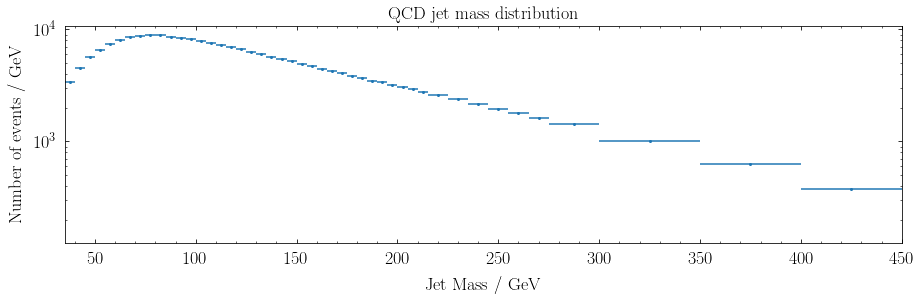

In [5]:
axislabelsize = 18

yerr = np.divide(1,np.sqrt(np.array(bincontents)))
xerr = np.multiply(0.5,np.array(binwidths))
plt.figure(figsize=(15,4))
plt.semilogy()
plt.xlim(35,450)
plt.errorbar(bincenters, bindensities, xerr=xerr, yerr=yerr,fmt='o',markersize=2)
plt.xlabel('Jet Mass / GeV', size=axislabelsize)
plt.ylabel('Number of events / GeV', size=axislabelsize)
plt.title('QCD jet mass distribution')
plt.show()

## Part 2: Train the NN

### Part 2a: Select and preprocess QCD and signal template data for training

### Select training and validation QCD samples

I will use the first 20% of the dataset for training and validation of the tagger, the rest will be used as test data for the tagger to generate final plots. Of this 20%, 80% will eventually be used for training, and 20% for validation.

For training, I'm only going to use events within the mass window 65 - 105 GeV.

In [8]:
#Split data into train&val and test
bgdatabinned_train_and_val = preprocessor.transform(bgdata[:int(len(bgdata)*0.2)])
bgdatabinned_test = preprocessor.transform(bgdata[int(len(bgdata)*0.2):])

#Select events only in 65-105 GeV mass window
bgdata65to105masswindow = np.array(bgdatabinned_train_and_val[8])
for i in range(9,16):
    bgdata65to105masswindow = np.append(bgdata65to105masswindow,bgdatabinned_train_and_val[i],axis=0)
rand.shuffle(bgdata65to105masswindow)
print(len(bgdata65to105masswindow))

68190


## Import and preprocess signal data for training

Here we import and process the six 'MI' datasets which act as a 'model independent' signal template for training. This data has already been selected within the 65 to 105 GeV mass window.

In [9]:
data_prefix = './Input-Data/PT1000/'
sigPnames = ['R2200-M80-2P_u',
            'R2200-M80-3P_udd',
            'R2200-M80-4P_u',
            'R2200-M80-2P_b',
            'R2200-M80-3P_ubb',
            'R2200-M80-4P_b'
           ]

sigPdatalist = [np.loadtxt(data_prefix + filename + '.all.dat') for filename in sigPnames]
sigPlengthmin = min([len(array) for array in sigPdatalist])
print("Smallest signal dataset:",sigPlengthmin)
numtotsig = len(sigPdatalist)*sigPlengthmin
#We arbitrarily chose to train on equal amounts of each MI data category,
#this means that the max data available for this is determined by the smallest
#signal category
print("Max signal available:",numtotsig)

#We will want to train on equal signal and background, which might limit the amount of
#signal data we can use
numpersignal = min(math.floor(len(bgdata65to105masswindow)/6),sigPlengthmin)
print("Number of signal events to be used:",numpersignal*6)
sigPdatainput = np.stack([dataset[:numpersignal] for dataset in sigPdatalist])
sigPdatainput = sigPdatainput.reshape((len(sigPdatainput)*len(sigPdatainput[0]),-1),order='F')

sigdatascaledbinned = preprocessor.transform(sigPdatainput)
sigdata = np.array([entry for sublist in sigdatascaledbinned if len(sublist) > 0 for entry in sublist])

Smallest signal dataset: 25959
Max signal available: 155754
Number of signal events to be used: 68190


### Select training and validation sets composed of signal and background

In [10]:
rand.shuffle(bgdata65to105masswindow)
rand.shuffle(sigdata)
valid_no = math.floor(len(sigdata)*0.2)
train_no = len(sigdata) - valid_no
test_no = len(bgdata65to105masswindow) - len(sigdata)
test_frac = test_no / len(bgdata65to105masswindow)
print('Training size = ', train_no)
print('Validation size = ', valid_no)

bgdata65to105masswindow_test = bgdata65to105masswindow[:test_no]
bgdata65to105masswindow_train = bgdata65to105masswindow[test_no:train_no + test_no]
bgdata65to105masswindow_val = bgdata65to105masswindow[test_no+train_no:test_no+train_no+valid_no]

sigdata_train = sigdata[:train_no]
sigdata_val = sigdata[train_no:valid_no+train_no]


data_train = np.append(bgdata65to105masswindow_train,
                       sigdata_train,
                       axis=0)
labels_train = np.append(np.zeros(train_no),np.ones(train_no))

data_val = np.append(bgdata65to105masswindow_val,sigdata_val,axis=0)
labels_val = np.append(np.zeros(valid_no),np.ones(valid_no))

perms_train = rand.permutation(2*train_no)
data_train = data_train[perms_train]
labels_train = labels_train[perms_train]

perms_val = rand.permutation(2*valid_no)
data_val = data_val[perms_val]
labels_val = labels_val[perms_val]

Training size =  54552
Validation size =  13638


### N-subjettiness basis selection

Currently our data contains the full 7-body N-subjettiness basis. Here I define how to select only subsets of this basis. Firstly, we noticed that performanced plateaud already at 6-body. Secondly, tau_1^2 = (m_J / pT)^2, so actually this variable can be excised.

The variable use_vars is the selection from now on.

In [11]:
twobody = [0,6]
threebody = [0,1,6,6+1,2*6]
fourbody = [0,1,2,6,6+1,6+2,2*6,2*6+1]
fivebody = [0,1,2,3,6,6+1,6+2,6+3,2*6,2*6+1,2*6+2]
sixbody = [0,1,2,3,4,6,6+1,6+2,6+3,6+4,2*6,2*6+1,2*6+2,2*6+3]
sixbody_without_tau12 = [0,1,2,3,4,6+1,6+2,6+3,6+4,2*6,2*6+1,2*6+2,2*6+3]
sevenbody = [0,1,2,3,4,5,6,6+1,6+2,6+3,6+4,6+5,2*6,2*6+1,2*6+2,2*6+3,2*6+4]
sevenbody_without_tau12 = [0,1,2,3,4,5,6+1,6+2,6+3,6+4,6+5,2*6,2*6+1,2*6+2,2*6+3,2*6+4]

#Choose basis to use from now on
use_vars = sixbody_without_tau12

### Part 2b: Train the NN

Firstly lets specify many of the parameters I will use for training.

In [12]:
#Now let's train a NN! This block specifies the parameters I will use

import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pickle as pickle
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss', patience=5,verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', patience=3,verbose=1)

mycallbacks=[early_stopping, reduce_LR]
batch_size=500

models = {}
models_hist = {}

ntries = 5

sig_predict={}
bg_predict={}

Using TensorFlow backend.


### Option 1: Load existing NN

We can load the existing model instead of training a new one

In [104]:
#Either load existing NN model in this block, or use the next block to train a new one
model_name = 'jet_mass_1000_80_sixbody_notau12'
from keras.models import load_model
models[model_name] = load_model('./saved_models/' + model_name + '.h5')

### Option 2: Train a new NN

This will train five times with different initial seeds, and pick the best as measured by area under the ROC curve in validation data.

In [13]:
#Train baby, train!
#This will train five times and pick the very best.

model_name = 'jet_mass_1000_80_sixbody_notau12'

numvars=len(use_vars)
aucs = list()
aucmax=0
for i in range(ntries):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=numvars))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model_hist = model.fit(data_train[:,use_vars], labels_train, epochs=100, batch_size=batch_size,
                        validation_data=(data_val[:,use_vars],labels_val),callbacks=mycallbacks,verbose=1)

    newauc = roc_auc_score(labels_val,model.predict(data_val[:,use_vars]))
    aucs.append(newauc)
    print(newauc)
    if newauc > aucmax:
        aucmax = newauc
        
        models[model_name] = model
        models_hist[model_name] = model_hist
        
print(aucs)

#Save the model
models[model_name].save('./saved_models/'+model_name+'.h5')
with open('./saved_models/hist_'+model_name, 'wb') as file_pi:
    pickle.dump(models_hist[model_name].history, file_pi)
    
with open('./saved_models/hist_'+model_name+'.h5', 'wb') as file_pi:
    pickle.dump(models_hist[model_name].history, file_pi)

Train on 109104 samples, validate on 27276 samples
Epoch 1/100
109104/109104 [==============================] - 1s - loss: 0.3760 - acc: 0.8387 - val_loss: 0.3641 - val_acc: 0.8424
Epoch 2/100
109104/109104 [==============================] - 1s - loss: 0.3531 - acc: 0.8489 - val_loss: 0.3566 - val_acc: 0.8477
Epoch 3/100
109104/109104 [==============================] - 1s - loss: 0.3504 - acc: 0.8489 - val_loss: 0.3565 - val_acc: 0.8476
Epoch 4/100
109104/109104 [==============================] - 1s - loss: 0.3487 - acc: 0.8496 - val_loss: 0.3540 - val_acc: 0.8483
Epoch 5/100
109104/109104 [==============================] - 1s - loss: 0.3474 - acc: 0.8503 - val_loss: 0.3523 - val_acc: 0.8496
Epoch 6/100
109104/109104 [==============================] - 1s - loss: 0.3460 - acc: 0.8509 - val_loss: 0.3521 - val_acc: 0.8498
Epoch 7/100
109104/109104 [==============================] - 1s - loss: 0.3449 - acc: 0.8514 - val_loss: 0.3511 - val_acc: 0.8520
Epoch 8/100
109104/109104 [============

105500/109104 [============================>.] - ETA: 0s - loss: 0.3340 - acc: 0.8562
Epoch 00026: reducing learning rate to 1.0000000656873453e-06.
109104/109104 [==============================] - 1s - loss: 0.3344 - acc: 0.8562 - val_loss: 0.3473 - val_acc: 0.8525
Epoch 28/100
109104/109104 [==============================] - 1s - loss: 0.3343 - acc: 0.8561 - val_loss: 0.3473 - val_acc: 0.8525
Epoch 29/100
109104/109104 [==============================] - 1s - loss: 0.3343 - acc: 0.8561 - val_loss: 0.3473 - val_acc: 0.8525
Epoch 30/100
106000/109104 [============================>.] - ETA: 0s - loss: 0.3339 - acc: 0.8561
Epoch 00029: reducing learning rate to 1.0000001111620805e-07.
109104/109104 [==============================] - 1s - loss: 0.3343 - acc: 0.8561 - val_loss: 0.3473 - val_acc: 0.8526
Epoch 31/100
109104/109104 [==============================] - 1s - loss: 0.3343 - acc: 0.8561 - val_loss: 0.3473 - val_acc: 0.8526
Epoch 32/100
109104/109104 [==============================] 

109104/109104 [==============================] - 1s - loss: 0.3407 - acc: 0.8531 - val_loss: 0.3503 - val_acc: 0.8515
Epoch 13/100
109104/109104 [==============================] - 1s - loss: 0.3399 - acc: 0.8538 - val_loss: 0.3539 - val_acc: 0.8487
Epoch 14/100
109104/109104 [==============================] - 1s - loss: 0.3396 - acc: 0.8542 - val_loss: 0.3513 - val_acc: 0.8487
Epoch 15/100
108000/109104 [============================>.] - ETA: 0s - loss: 0.3392 - acc: 0.8535
Epoch 00014: reducing learning rate to 0.00010000000474974513.
109104/109104 [==============================] - 1s - loss: 0.3389 - acc: 0.8537 - val_loss: 0.3547 - val_acc: 0.8487
Epoch 16/100
109104/109104 [==============================] - 1s - loss: 0.3357 - acc: 0.8558 - val_loss: 0.3463 - val_acc: 0.8515
Epoch 17/100
109104/109104 [==============================] - 1s - loss: 0.3347 - acc: 0.8564 - val_loss: 0.3466 - val_acc: 0.8517
Epoch 18/100
109104/109104 [==============================] - 1s - loss: 0.334

Let's plot the training and validation loss.

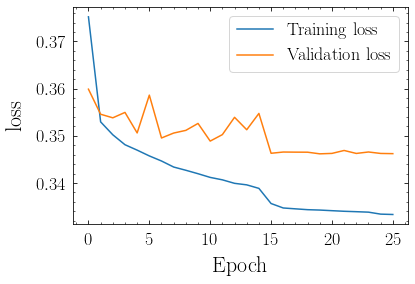

In [14]:
#Let's plot loss during training
plt.close('all')

for key in models_hist:
    plt.plot(models_hist[key].history['loss'],label='Training loss')
    plt.plot(models_hist[key].history['val_loss'],label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

## Part 3: Looking at the results

### Tagger efficiency on QCD

Here I choose a set of tagger operating thresholds and plot the efficiency of the tagger on QCD as a function of QCD jet mass.

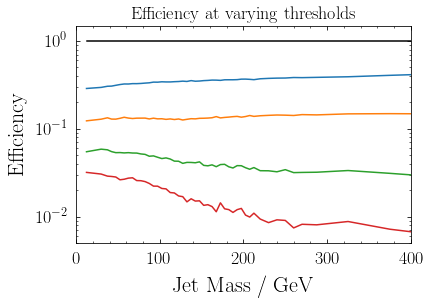

In [15]:
mymodel=models['jet_mass_1000_80_sixbody_notau12']
bgpredicttable = [mymodel.predict(data[:,sixbody_without_tau12]) for data in bgdatabinned_test]

thresholds = [0,0.2,0.55,0.8,0.89]
binefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in bgpredicttable]
    for threshold in thresholds
]
bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in bgpredicttable]
    for threshold in thresholds
]

plt.close('all')
colours=('k','C0','C1','C2','C3')
for i in range(0,len(thresholds)):
    plt.plot(bincenters,binefficiencies[i],color=colours[i])
plt.semilogy()
plt.xlim([0,400])
plt.ylim([0.005,1.5])
plt.xlabel('Jet Mass / GeV')
plt.ylabel('Efficiency')
plt.title('Efficiency at varying thresholds')
plt.show()

### Jet mass distributions after cutting QCD with the tagger

Let's plot QCD jet mass distribution after tagging at various thresholds

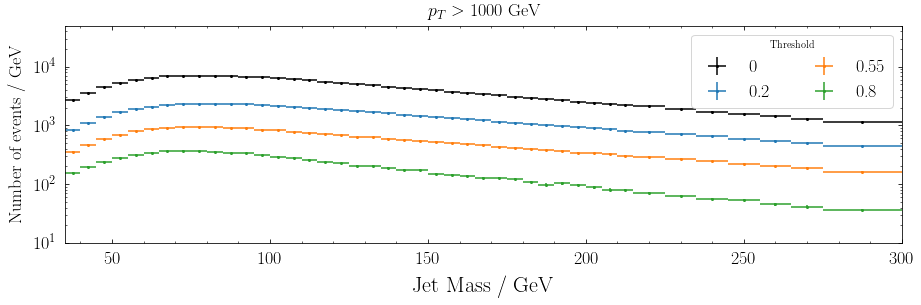

In [16]:
threshold_choices=[0,1,2,3]

axislabelsize = 18

plt.close('all')
plt.figure(figsize=(15,4))

colours=('k','C0','C1','C2','C3')

yerr0 = np.multiply(np.divide(np.sqrt(np.add(np.array(bincontents),1)),binwidths),0.89)
yerrs = np.divide(np.sqrt(np.add(np.array(bincutcounts),1)),binwidths)
xerr = np.multiply(0.5,np.array(binwidths))

plt.semilogy()
plt.ylim(10,5e4)
plt.xlim(35,300)
plt.xlabel('Jet Mass / GeV')
plt.ylabel('Number of events / GeV', size=axislabelsize)
plt.title(r'$p_T > 1000$ GeV', size=axislabelsize)
for i in range(0,len(threshold_choices)):
    #yerr = np.sqrt(np.add(np.array(bincutcounts[i]),1))
    plt.errorbar(bincenters,np.divide(bincutcounts[threshold_choices[i]],binwidths),
                 xerr=xerr, yerr=yerrs[threshold_choices[i]],fmt='o',markersize=2,
                 color=colours[i],label=thresholds[i])
plt.legend(title='Threshold',ncol=2)
plt.show()

### Adding a signal

First let's import and preprocess some signals to inject on top of the QCD background. We load:


'no-mass-cut-data/R2200-M100-AA40_b.all.dat'

p p > Z'(2.2 TeV) > Z H, Z > nu nu, H(100 GeV) > AA(40 GeV) > 4b


'no-mass-cut-data/R2200-M200-WWhad.all.dat'

p p > Z' > Z H, Z > nu nu, H(200 GeV) > WW > 4q.

In [105]:
#Lets import some signals to make a plot of the tagger acting on bg + signal

signal100 = preprocessor.transform(np.loadtxt('no-mass-cut-data/R2200-M100-AA40_b.all.dat'))
signal200 = preprocessor.transform(np.loadtxt('no-mass-cut-data/R2200-M200-WWhad.all.dat'))
sig100predicttable = [mymodel.predict(data[:,sixbody_without_tau12]) if len(data) > 0 else np.array([0.])
                      for data in signal100]
sig200predicttable = [mymodel.predict(data[:,sixbody_without_tau12]) if len(data) > 0 else np.array([0.])
                      for data in signal200]
sigbincontents200 = [len(row) for row in signal200]
sigbincontents100 = [len(row) for row in signal100]

sig100binefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in sig100predicttable]
    for threshold in thresholds
]
sig100bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in sig100predicttable]
    for threshold in thresholds
]
sig100bincutdensities = np.divide(sig100bincutcounts,binwidths)

sig200binefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in sig200predicttable]
    for threshold in thresholds
]
sig200bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in sig200predicttable]
    for threshold in thresholds
]
sig200bincutdensities = np.divide(sig200bincutcounts,binwidths)

sigplusbgcut = [np.add(np.add(np.multiply(sig200bincutcounts[i],0.25),
                       np.array(bincutcounts[i])),
                       np.multiply(sig100bincutcounts[i],0.6))
                for i in range(0,len(bincutcounts))]

### Plot effect of tagger on QCD + signals

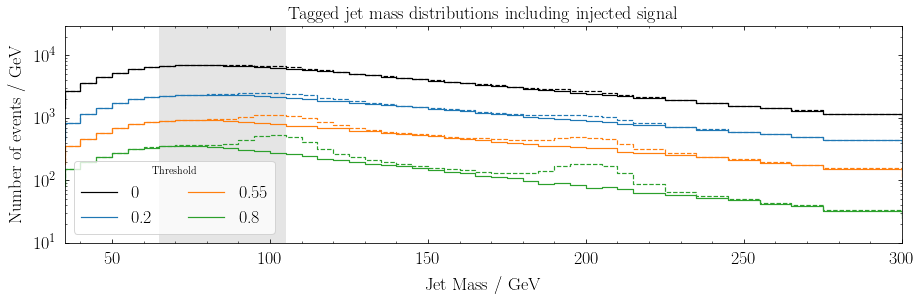

In [103]:
#Now lets plot that bitch!

axislabelsize = 18

plt.close('all')

threshold_choices=[0,1,2,3]
colours=['k','C0','C1','C2','C3']

plt.figure(figsize=(15,4))


yerr0 = np.multiply(np.divide(np.sqrt(np.add(np.array(bincontents),1)),binwidths),0.89)
yerrs = np.divide(np.sqrt(np.add(np.array(bincutcounts),1)),binwidths)
xerr = np.multiply(0.5,np.array(binwidths))

axes2d[0].semilogy()
axes2d[0].axvspan(65, 105, alpha=0.2, facecolor='gray')
axes2d[0].set_ylim(10,3e4)
axes2d[0].set_xlim(35,300)
#plt.xlabel('Jet Mass / GeV')
axes2d[0].set_ylabel('Number of events / GeV', size=axislabelsize)
axes2d[0].set_title(r'$p_T > 1000$ GeV', size=axislabelsize)
axes2d[0].errorbar(bincenters, np.multiply(bindensities,0.8), xerr=xerr, yerr=yerr0,fmt='o',markersize=2,color='k')
for i in range(0,len(threshold_choices)):
    #yerr = np.sqrt(np.add(np.array(bincutcounts[i]),1))
    axes2d[0].errorbar(bincenters,np.divide(bincutcounts[threshold_choices[i]],binwidths),
                 xerr=xerr, yerr=yerrs[threshold_choices[i]],fmt='o',markersize=2,color=colors[i])

linewidth=1.2
plt.semilogy()
plt.ylim(10,3e4)
plt.xlim(35,300)
plt.axvspan(65, 105, alpha=0.2, facecolor='gray')
plt.xlabel('Jet Mass / GeV', size=axislabelsize)
plt.ylabel('Number of events / GeV', size=axislabelsize)
#plt.title(r'$p_T > 500$ GeV')
for i in range(0,len(threshold_choices)):
    plt.step(binboundaries[:len(binboundaries)-1],
            np.divide(bincutcounts[threshold_choices[i]],binwidths),
            where='post',color=colours[i],linewidth=linewidth,label=thresholds[i])
    
for i in range(0,len(threshold_choices)):
    plt.step(binboundaries[:len(binboundaries)-1],
             np.divide(sigplusbgcut[threshold_choices[i]],binwidths),
             where='post',color=colours[i],linestyle='--',linewidth=linewidth)
plt.legend(title='Threshold',ncol=2)
plt.title('Tagged jet mass distributions including injected signal')
plt.show()